# How to calculate the steady state of an open quantum system
**Compute the long time limit density matrix of Lindblad dynamics from a time-independent generator**

For open system dynamics, Boulder Opal enables you to compute the steady state solution of the GKS–Lindblad master equation.
Often, the steady state is a good approximation to the actual density operator in a physical experiment.
Furthermore, it can give rise to interesting physical features such as electromagnetically induced transparency or negative Wigner functions.

In this user guide, the steady state for a driven three level atom subject to sponatneous decay and dephasing noise is computed.
This dark state cannot absorb nor emit any photons.
Through this example, you will learn how to compute the steady state for arbitrary quantum systems with Boulder Opal.

## Summary workflow

### 1. Define the physical system
First, define the physical parameters of your system and create the objects defining the Hamiltonian of your system and the Lindblad operators representing the non-coherent dynamical terms. Unlike most other functions in Boulder Opal, the input Hamiltonian is not a PWC, but a `Tensor`, `np.ndarray`, or an `spmatrix`.


### 2. Compute the steady state
Define a graph node for the steady state calculation using `graph.steady_state`.
This node takes your `hamiltonian`, `lindblad_terms`, and an optional `method` for the calculation as an input. It outputs the steady state density matrix.
Afterwards, exectute the graph and print the result.

## Example: Dark state in a three level atom system

This example discusses the computation of the dark state for electromagnetically induced transparency (EIT) in a three level atom in a $\Lambda$ configuration, where $| 1 \rangle$ is the ground state, $| 2 \rangle$ is a metastable state and $| 3 \rangle$ is the excited state.
Although there is an allowed transition between $| 1 \rangle$ and $| 3 \rangle$ as well as a transition between $| 2 \rangle$ and $| 3 \rangle$, the transition between $| 1 \rangle$ and $| 2 \rangle$ is forbidden.
Typically, EIT is achieved by driving the allowed transitions of the atom through two (near) resonant lasers.
For simplicity, we assume that the lasers are exactly on resonance with the atom's transitions, so that all detunings are zero.

The system Hamiltonian in the rotating frame and under the rotating wave approximation can be written as
$$
H = - \frac{1}{2} (\Omega_{\rm p} | 1 \rangle \langle 3 | + \Omega_{\rm c} | 2 \rangle \langle 3 |) + H.c.,
$$
where $\Omega_{\rm p}$ is the probe field Rabi frequency corresponding to the $| 1 \rangle$-$| 3 \rangle$ driving, $\Omega_{\rm c}$ is the control field Rabi frequency corresponding to the $| 2 \rangle$-$| 3 \rangle$ driving and $H.c.$ denotes the Hermitian conjugate of the entire expression.

Furthermore, we include Lindblad operator terms $\gamma_{1} {\mathcal D}[| 1 \rangle \langle 3 |]$ and $\gamma_{2} {\mathcal D}[| 2 \rangle \langle 3 |]$ corresponding to spontaneous decay from $| 3 \rangle$ to $| 1 \rangle$ at rate $\gamma_{1}$ and from $| 3 \rangle$ to $| 2 \rangle$ at rate $\gamma_{2}$, respectively.
Here, ${\mathcal D}[X]$ is a superoperator whose action is defined by
$$
{\mathcal D}[X]\rho := X \rho X^\dagger - \frac{1}{2}\left( X^\dagger X \rho + \rho X^\dagger X \right)
$$
for any system operator $X$.

We solve for the steady state of this system with Boulder Opal and compare the result with the analytical solution.
There exists a unique eigenvector of the total Lindblad superoperator with eigenvalue zero, which is the steady state of the system.
This is the so-called [dark state](https://en.wikipedia.org/wiki/Dark_state) $| {\rm D} \rangle$ of the three level atom, which is known to be
$$
| {\rm D} \rangle = \frac{1}{\Omega} (\Omega_{\rm c} | 1 \rangle - \Omega_{\rm p} | 2 \rangle),
$$
where $\Omega = \sqrt{\Omega_{\rm p}^2 + \Omega_{\rm c}^2}$, and with a corresponding density matrix
$$
\rho_{\rm ss}
=   | {\rm D} \rangle \langle {\rm D} |
=   \frac{1}{\Omega^2}
    \begin{pmatrix}
        \Omega_c^2 & -\Omega_c \Omega_p & 0 \\
        -\Omega_c \Omega_p & \Omega_p^2 & 0 \\
        0 & 0 & 0
    \end{pmatrix}.
$$


In [1]:
# Import the relevant packages.
import numpy as np
import boulderopal as bo
import qctrlvisualizer as qv

Your task (action_id="1828014") has started.
Your task (action_id="1828014") has completed.
Steady state solution:
[[ 0.64+0.j -0.48-0.j -0.  +0.j]
 [-0.48-0.j  0.36+0.j  0.  -0.j]
 [ 0.  -0.j -0.  +0.j -0.  -0.j]]

Dark state density matrix:
[[ 0.64+0.j -0.48-0.j  0.  +0.j]
 [-0.48+0.j  0.36+0.j  0.  +0.j]
 [ 0.  +0.j  0.  -0.j  0.  +0.j]]


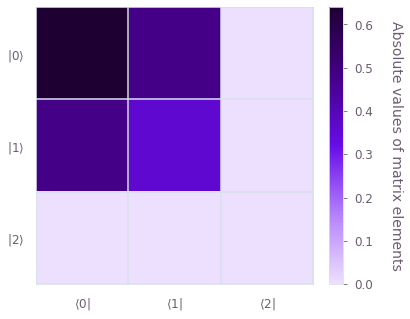

In [2]:
# Define physical parameters.
omega_c = 2 * np.pi * 80e6  # Hz
omega_p = 2 * np.pi * 60e6  # Hz

gamma_1 = 2 * np.pi * 60e3  # Hz
gamma_2 = 2 * np.pi * 50e3  # Hz

# Create graph object.
graph = bo.Graph()

# Define basis vectors.
state_one = graph.fock_state(3, 0)
state_two = graph.fock_state(3, 1)
state_three = graph.fock_state(3, 2)

# Construct the Hamiltonian.
hamiltonian = -omega_p * graph.hermitian_part(
    graph.outer_product(state_one, state_three)
) - omega_c * graph.hermitian_part(graph.outer_product(state_two, state_three))

# Define the Lindblad operators.
lindblad_terms = [
    (gamma_1, graph.outer_product(state_one, state_three)),
    (gamma_2, graph.outer_product(state_two, state_three)),
]

# Compute the steady state with the solver in Boulder Opal.
steady_state = graph.steady_state(
    hamiltonian=hamiltonian, lindblad_terms=lindblad_terms, name="steady_state"
)

# Compute the dark state analytically.
Omega = np.sqrt(omega_p**2 + omega_c**2)
dark_state = (omega_c * state_one - omega_p * state_two) / Omega
rho_ss = graph.outer_product(dark_state, dark_state, name="analytical_dark_state")

# Perform the calculations and compare the results.
result = bo.execute_graph(
    graph=graph, output_node_names=["steady_state", "analytical_dark_state"]
)
print("Steady state solution:")
print(result["output"]["steady_state"]["value"].round(6))
print()
print("Dark state density matrix:")
print(result["output"]["analytical_dark_state"]["value"].round(6))

# Plot the steady state density matrix.
qv.plot_density_matrix(result["output"]["steady_state"]["value"])